# 1. CREATE MESH USING SMPL MODEL --> POUR GROUPE 2 (Mouvement)
Attention des path vers des repectoire car c'est adapté pour ma machine!

### Definite SMPLX class for SMPLX model

In [1]:

import torch
from body_model import BodyModel
from utils import rodrigues_2_rot_mat#, rotation6d_2_rot_mat
from lbs import lbs, batch_rodrigues
import os
import numpy as np

# Define the project root directory
# find the path to the project root directory
# Define the project root directory
# find the path to the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))


# Define the path to SMPLX_MALE.npz using an absolute path
SMPLX_MODEL_MALE_PATH = os.path.join(PROJECT_ROOT, 'test smplx/smplx_lockedhead_20230207/models_lockedhead/smplx/SMPLX_MALE.npz')




class SMPLX(BodyModel):
    def __init__(self, num_betas=16, **kwargs):
        super().__init__(bm_fname=SMPLX_MODEL_MALE_PATH, num_betas=num_betas, num_expressions=0, **kwargs)

    def forward(self, pose_body, betas, use_rodrigues=True):
        
        device = pose_body.device
        for name in ['init_pose_hand', 'init_pose_jaw','init_pose_eye', 'init_v_template', 'init_expression', 
                    'shapedirs', 'exprdirs', 'posedirs', 'J_regressor', 'kintree_table', 'weights', 'f']:
            _tensor = getattr(self, name)
            setattr(self, name, _tensor.to(device))

        batch_size = pose_body.shape[0]
        
        #trans = pose_body[:, :3] # No translation
        pose_hand = self.init_pose_hand.expand(batch_size, -1)
        pose_jaw = self.init_pose_jaw.expand(batch_size, -1)
        pose_eye = self.init_pose_eye.expand(batch_size, -1)
        v_template = self.init_v_template.expand(batch_size, -1, -1)
        expression = self.init_expression.expand(batch_size, -1)

        init_pose = torch.cat([pose_jaw, pose_eye, pose_hand], dim=-1) # [B, 99] full of zeros
        if not use_rodrigues:
            init_pose = rodrigues_2_rot_mat(init_pose) # [B, 99] -> [B, 33, 3, 3]
        #full_pose = torch.cat([pose_body[:, 3:], init_pose], dim=-1)
        
        full_pose = torch.cat([pose_body, init_pose], dim=-1) # No translation, concat of Pose body [B, 66] and init_pose [B, 99] = [B, 165]
        
        
        shape_components = torch.cat([betas, expression], dim=-1)
        shapedirs = torch.cat([self.shapedirs, self.exprdirs], dim=-1)
        

        verts, joints = lbs(betas=shape_components, pose=full_pose, v_template=v_template,
                        shapedirs=shapedirs, posedirs=self.posedirs, J_regressor=self.J_regressor,
                        parents=self.kintree_table[0].long(), lbs_weights=self.weights, pose2rot=use_rodrigues)
        
        faces = self.f.expand(batch_size, -1, -1)
        #textures = torch.ones_like(verts)


        # joints = joints + trans.unsqueeze(dim=1)
        # verts = verts + trans.unsqueeze(dim=1)
        
        return dict(verts=verts, faces=faces, joints=joints)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
smplx = SMPLX().to(device)

### Functions to visualize one pose (at a given time) and to visulyze a sequence of mouvement 

In [3]:
# visualize the point cloud at a given pose before and after translation


from matplotlib import pyplot as plt

def visualize_frame(verts, trans):
    # visualize the mesh
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='gray', marker='o', s=0.01)
    ax1.set_title("Mesh before translation")
    val_min = verts.min()
    val_max = verts.max()
    ax1.set_xlim(val_min, val_max)
    ax1.set_ylim(val_min, val_max)
    ax1.set_zlim(val_min, val_max)


    verts_ = verts + trans 
    ax2.scatter(verts_[:, 0], verts_[:, 1], verts_[:, 2], c='gray', marker='o', s=0.01)
    ax2.set_title("Mesh after translation")
    val_min = verts_.min()
    val_max = verts_.max()
    ax2.set_xlim(val_min, val_max)
    ax2.set_ylim(val_min, val_max)
    ax2.set_zlim(val_min, val_max)

In [4]:
# Visualize the sequences of point clouds and meshes of movement 

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def visualize_seq(verts, faces):
    fig = plt.figure(figsize=(12, 6))
    ax_pc = fig.add_subplot(121, projection='3d')
    ax_mesh = fig.add_subplot(122, projection='3d')

    total_frames = len(verts)

    def update_view(frame):
        ax_pc.cla()
        ax_mesh.cla()

        val_min = verts.min()
        val_max = verts.max()

        # Extract the point cloud and theta for the current frame
        gt_pc = verts[frame].cpu().numpy()

        # Plot point cloud
        ax_pc.scatter(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], s=0.01, c='gray')
        ax_pc.set_title(f"Point Cloud Frame {frame + 1}")
        ax_pc.set_xlim(val_min, val_max)
        ax_pc.set_ylim(val_min, val_max)
        ax_pc.set_zlim(val_min, val_max)
        ax_pc.view_init(elev=20, azim=50)


        # Plot mesh 
        ax_mesh.plot_trisurf(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], triangles=faces, color='green', alpha=0.2)
        ax_mesh.set_title(f"Mesh Frame {frame + 1}")
        ax_mesh.set_xlim(val_min, val_max)
        ax_mesh.set_ylim(val_min, val_max)
        ax_mesh.set_zlim(val_min, val_max)
        ax_mesh.view_init(elev=20, azim=50)

    # Create the animation for all frames across all batches
    ani = FuncAnimation(fig, update_view, frames=total_frames)
    plt.close(fig)  # Close the figure to avoid displaying a static plot

    return ani


### Load CMU data and CREATE MESHES BY USING the SMPLX model

In [5]:
# LOAD CMU DATASET
import numpy as np
import matplotlib.pyplot as plt

# Load the npz file
npz_file_path = "CMU/01/01_02_poses.npz"
npz_smplx = "smplx_lockedhead_20230207/models_lockedhead/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)  

# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
    print(f"Key: {key}")
    try : 
        if npz_file[key].shape == ():
            print(f"Content: {npz_file[key]}")
        else:
            print(f"Shape: {npz_file[key].shape}")
    except:
         
        continue
    data[key] = npz_file[key]
    print(data[key].shape)
print("Data extracted.")

Extracting data...
Key: trans
Shape: (4346, 3)
(4346, 3)
Key: gender
Content: male
()
Key: mocap_framerate
Content: 120.0
()
Key: betas
Shape: (16,)
(16,)
Key: dmpls
Shape: (4346, 8)
(4346, 8)
Key: poses
Shape: (4346, 156)
(4346, 156)
Data extracted.


In [6]:
# Create MESHES 
pose_body = torch.tensor(data['poses'][:-1, :66], dtype=torch.float32).to(device) # 21 joints (63 vec) 
beta = torch.tensor(data['betas'], dtype=torch.float32).unsqueeze(0).repeat(pose_body.shape[0], 1).to(device) 

meshes = smplx(pose_body=pose_body, betas=beta, use_rodrigues=True)
verts = meshes['verts']#.verts_padded()
faces = meshes['faces']#.faces_packed()
trans = data['trans']


### VISUALIZE 

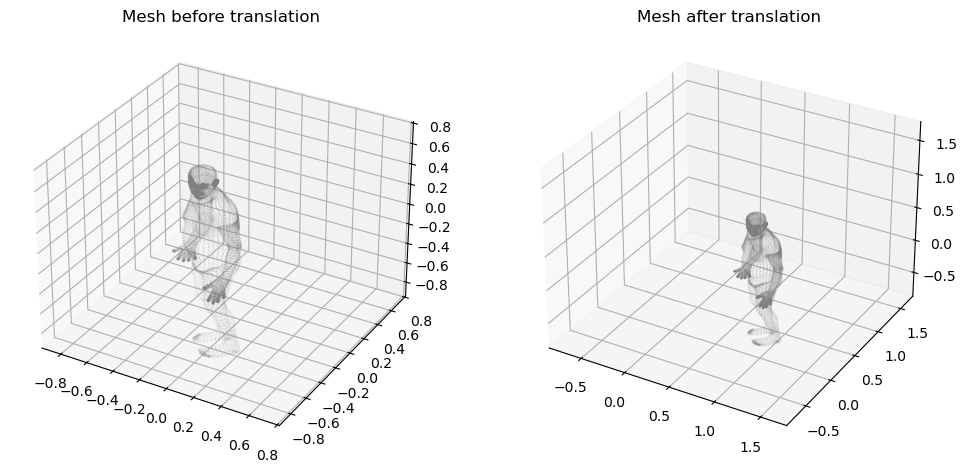

In [7]:
# VUSU A POSE 
f = 0
visualize_frame(verts[f], trans[f])

In [8]:
# VISU A SEQUENCE 

train_animation = visualize_seq(verts[:200:20], faces[0])
display(HTML(train_animation.to_jshtml()))

# partie faite par Haninne


In [9]:
def visualize_seq_with_translation(verts, faces, trans):
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(12, 6))
    ax_pc = fig.add_subplot(121, projection='3d')
    ax_mesh = fig.add_subplot(122, projection='3d')

    total_frames = len(verts)

    def update_view(frame):
        ax_pc.cla()
        ax_mesh.cla()

        val_min = verts.min().cpu().item()
        val_max = verts.max().cpu().item()

        # Apply translation to the current frame
        translated_verts = verts[frame] + trans[frame]

        gt_pc = translated_verts.cpu().numpy()

        # Point cloud
        ax_pc.scatter(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], s=0.01, c='gray')
        ax_pc.set_title(f"Point Cloud Frame {frame + 1}")
        ax_pc.set_xlim(val_min, val_max)
        ax_pc.set_ylim(val_min, val_max)
        ax_pc.set_zlim(val_min, val_max)
        ax_pc.view_init(elev=20, azim=50)

        # Mesh
        ax_mesh.plot_trisurf(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], triangles=faces, color='green', alpha=0.2)
        ax_mesh.set_title(f"Mesh Frame {frame + 1}")
        ax_mesh.set_xlim(val_min, val_max)
        ax_mesh.set_ylim(val_min, val_max)
        ax_mesh.set_zlim(val_min, val_max)
        ax_mesh.view_init(elev=20, azim=50)

    ani = FuncAnimation(fig, update_view, frames=total_frames)
    plt.close(fig)
    return ani

In [10]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # Allow large animation

trans_tensor = torch.tensor(data['trans'], dtype=torch.float32).to(device)
#ani = visualize_seq_with_translation(verts[:1000:40], faces[0].cpu().numpy(), trans_tensor[:1000:40])
#HTML(ani.to_jshtml())


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class CoordinateSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)   
        self.labels = torch.tensor(labels, dtype=torch.float32)            

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Random 3D input sequences and corresponding 2D targets
print(data["trans"].shape)
input_data = [data["trans"]]
labels = [data["poses"]]

# Split into train and test sets
#train_seq, test_seq, train_labels, test_labels = train_test_split(
#    input_data, labels, test_size=0.2, random_state=42
#)
train_seq,train_labels = input_data, labels

train_dataset = CoordinateSequenceDataset(train_seq, train_labels)
#test_dataset = CoordinateSequenceDataset(test_seq, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
sequence_length = len(data['trans'])
input_size = 3
hidden_size = 23
output_size = data["poses"].shape[1]
num_epochs = 20
batch_size = 64
learning_rate = 0.001
num_layers = 2


class myGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(myGRU, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(device)

        # Forward propagate through GRU
        out, _ = self.rnn(x, h0)  # out: (batch, seq_len, hidden_size)

        # Apply linear layer to each timestep's output
        out = self.fc(out)  # out: (batch, seq_len, output_size)
        return out

model = myGRU(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

n_total_steps = len(train_loader)
print(len(train_loader))
for epoch in range(num_epochs):
    for i, (sequences, targets) in enumerate(train_loader):  
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



# with torch.no_grad():
#     mean_loss = 0
#     for sequences, targets in test_loader:
#         sequences = sequences.to(device)
#         targets = targets.to(device)
#         outputs = model(sequences)

#         loss = criterion(outputs, targets)
#         mean_loss += loss.item()

#         print(f'Test loss: {loss.item():.4f}')

#     mean_loss /= len(test_loader)
#     print(f'mean test loss: {mean_loss:.4f} \n out of {len(test_loader)} batches')


(4346, 3)
1
Epoch [1/20], Step [1/1], Loss: 0.1902
Epoch [2/20], Step [1/1], Loss: 0.1860
Epoch [3/20], Step [1/1], Loss: 0.1820
Epoch [4/20], Step [1/1], Loss: 0.1783
Epoch [5/20], Step [1/1], Loss: 0.1748
Epoch [6/20], Step [1/1], Loss: 0.1714
Epoch [7/20], Step [1/1], Loss: 0.1681
Epoch [8/20], Step [1/1], Loss: 0.1649
Epoch [9/20], Step [1/1], Loss: 0.1618
Epoch [10/20], Step [1/1], Loss: 0.1587
Epoch [11/20], Step [1/1], Loss: 0.1557
Epoch [12/20], Step [1/1], Loss: 0.1526
Epoch [13/20], Step [1/1], Loss: 0.1495
Epoch [14/20], Step [1/1], Loss: 0.1463
Epoch [15/20], Step [1/1], Loss: 0.1432
Epoch [16/20], Step [1/1], Loss: 0.1400
Epoch [17/20], Step [1/1], Loss: 0.1367
Epoch [18/20], Step [1/1], Loss: 0.1333
Epoch [19/20], Step [1/1], Loss: 0.1299
Epoch [20/20], Step [1/1], Loss: 0.1264


# 2. CODE TO READ CMU DATA 
### ATTENTION: Groupe 1, vous n'avez pas tout des codes pour creer des meshes. Donc ne pas tester des codes précédament ! Concentrer seulement sur cette partie. 
### Il faut que vous voyez avec le goupe 2 pour recuperer des données de CMU! 

### Load one sequence of CMU data 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the npz file
npz_file_path = "CMU/01/01_02_poses.npz"
npz_smplx = "smplx_lockedhead_20230207/models_lockedhead/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)  

# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
    print(f"Key: {key}")
    try : 
        if npz_file[key].shape == ():
            print(f"Content: {npz_file[key]}")
        else:
            print(f"Shape: {npz_file[key].shape}")
    except:
         
        continue
    data[key] = npz_file[key]
    print(data[key].shape)
print("Data extracted.")

Extracting data...
Key: trans
Shape: (4346, 3)
(4346, 3)
Key: gender
Content: male
()
Key: mocap_framerate
Content: 120.0
()
Key: betas
Shape: (16,)
(16,)
Key: dmpls
Shape: (4346, 8)
(4346, 8)
Key: poses
Shape: (4346, 156)
(4346, 156)
Data extracted.


### RECUPERER LE TRANSLATATION 

In [ ]:
trans = data['trans']

### Visualiez  transation 

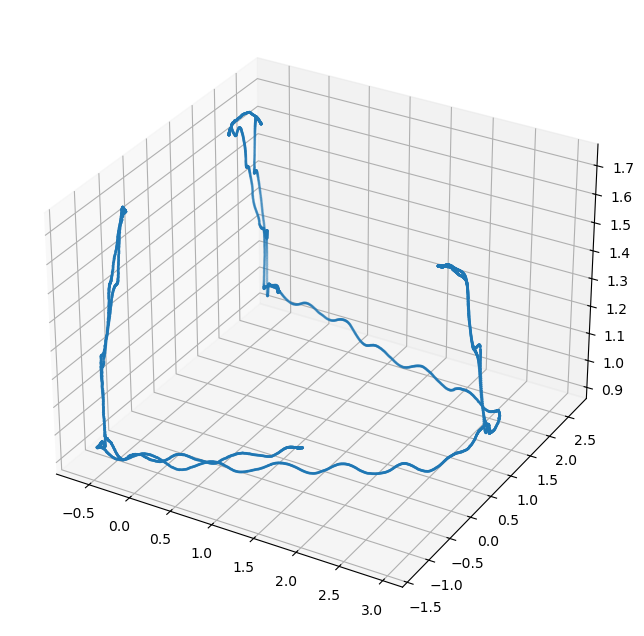

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:,1], trans[:,2], s=1, label='translation')

In [13]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from openai import OpenAI


text = "The boy goes to the sofa, then he sits on the chair and finally he lays on the bed."


client = OpenAI(
 base_url="https://openrouter.ai/api/v1",
 api_key="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",
)


completion = client.chat.completions.create(
 model="cognitivecomputations/dolphin3.0-r1-mistral-24b:free",
 messages=[
   {
     "role": "user",
     "content": "You are an assistant that helps people find objects in a room. You should determine targets objects in the text description that we will give you."},
               {
                   "role": "assistant",
                   "content": """
                       Here are the examples:
                     
                       Please note that targets should be split by ",".
                       1. Walk next to the bed and then sit on the chair. Please answer:
                           bed,chair
                       2. Sit on the sofa that is next to the table and head to the door. Please answer:
                           sofa,table,door
                       3. sit on the chair that is next to the table. Please answer:
                           chair
                       4. Stand up from the chair that is next to the tables and go to the toilet. Please answer:
                           toilet
                   """,
               },
               {
                   "role": "user",
                   "content": f"""
                       The text description is: {text}.
                       Answer in English.
                       Answer should be in the following format without any explanations: target_object_1, target_object_2, target_object_3, ....
                       Don't give the anchor object, only targets, if an object is used to find the position of an another one, don't give it like exemple 3.
                       If there is no object in the text, return : error 
                   """,
               }
           ]
)


answer=completion.choices[0].message.content
print(answer)
names = answer.split(",")
print(names)

sofa,chair,bed
['sofa', 'chair', 'bed']


In [15]:
import numpy as np
import matplotlib.pyplot as plt


# Load the npz file
npz_file_path = "CMU/01/01_02_poses.npz"
npz_smplx = "smplx_lockedhead_20230207/models_lockedhead/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True) 


# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
   print(f"Key: {key}")
   try :
       if npz_file[key].shape == ():
           print(f"Content: {npz_file[key]}")
       else:
           print(f"Shape: {npz_file[key].shape}")
   except:
       
       continue
   data[key] = npz_file[key]
   print(data[key].shape)
print("Data extracted.")


coor = []
lcoor = []
lfinale = []
trans = data['trans']
x = 0
y = 0
z = 0
nbpoints = 10
ecart = len(trans)//nbpoints
for i in range(len(trans)):
   x += trans[i][0]
   y += trans[i][1]
   z += trans[i][2]
   lcoor.append(np.array(trans[i]).tolist())
   if i % ecart == 0:
       coor.append((x, y, z))
       lfinale.append(lcoor)
       lcoor = []
print(trans)
print(lfinale)
print(coor)


Extracting data...
Key: trans
Shape: (4346, 3)
(4346, 3)
Key: gender
Content: male
()
Key: mocap_framerate
Content: 120.0
()
Key: betas
Shape: (16,)
(16,)
Key: dmpls
Shape: (4346, 8)
(4346, 8)
Key: poses
Shape: (4346, 156)
(4346, 156)
Data extracted.
[[ 1.34283217 -0.21062366  0.96222237]
 [ 1.34144093 -0.21055906  0.96199171]
 [ 1.34006426 -0.21090325  0.96175704]
 ...
 [-0.46998671  2.62710242  0.99933278]
 [-0.46907922  2.62679275  0.99987449]
 [-0.4681302   2.62673145  1.00014205]]
[[[1.3428321694609648, -0.21062365644027858, 0.9622223733798708]], [[1.3414409321193328, -0.21055906334761562, 0.9619917146218444], [1.3400642636619087, -0.21090324720220194, 0.9617570391794021], [1.3387878767788413, -0.2112445523495986, 0.9615071219939483], [1.337904117280355, -0.21124152973253418, 0.9612666927836748], [1.3369306622433859, -0.21125325313976334, 0.9609257518885598], [1.335857536892934, -0.21133445728874453, 0.9605379194948406], [1.3345704199292328, -0.211186672729826, 0.9603948762883733]

In [16]:
import json


def norme(l):
  return ( l[0]**2 + l[1]**2 + l[2]**2)


temps = []
init = 0
fin = 0
for i in range(len(coor)):
  fin += len(lfinale[i])
  temps.append((init, fin))
  init = fin


# Créer un dictionnaire Python
donnees = {
  "nom": [],
  "coordonnees": [],
  "temps": [],
  "vecteurs": ["v1","v2"],
}


donnees["nom"] = names
donnees["coordonnees"] = coor
donnees["temps"] = temps
donnees["vecteurs"] = lfinale


# Sauvegarder dans un fichier JSON
with open("fichier.json", "w", encoding="utf-8") as f:
  json.dump(donnees, f, indent=4)


# A VOUS DE FAIRE LE TRAVAIL ! 